In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from collections import defaultdict
from IPython.display import clear_output, display

In [6]:
class args(object):
    
    graph = 'Simplest' #[Simplest, Colour, Predicting]
    path = 'Simple' #[Simple, Cycle, predicting]
    
#     graph = 'Colour' 
#     path = 'Cycle' 
    
    x = 5
    y = 4
    
    num_nodes = x * y
    
    num_colour = 5
    
    simplest = True
    root = 1
    num_pairs = 10000
    prob = 0.5
    random_seed = 101
    

In [7]:
def CreatingSimplestGraph():

    '''
    For creating the simplest graph
    '''
    x = args.x
    y = args.y
    root = args.root
    num_nodes = args.num_nodes
    random_seed = args.random_seed
    if random_seed != None:
        np.random.seed(random_seed)
    assert num_nodes%2 ==0 ,'num_nodes % 2 should == 0'
    num_colour = num_nodes//2 
    args.num_colour = num_colour
    colour_list = np.arange(num_colour+1)[1:]
    colour_assign = np.array(list(colour_list)*2)
    np.random.shuffle(colour_assign)

    colour_dict = {}
    for i in range(num_nodes):
        colour_dict[i+1] = {'Colour': colour_assign[i]}

    G = nx.convert_node_labels_to_integers(nx.grid_2d_graph(x,y),1)
    nx.set_node_attributes(G, colour_dict)

    node_list = list(G.nodes)
    # node_list.remove(root)
    colour_collection = defaultdict(list)

    for node in node_list:
        colour_collection[G.nodes[node]['Colour']].append(node)

    colour_collection.pop(G.nodes[root]['Colour'],None)

    # if the # colour > 1/2 # nodes: some colours will only have one nodes on the graph; hence, it can't create negative pair.

    for value in colour_collection.values():
        assert len(value) >= 2, 'Every colour has to be used twice on the graph or the negative pair can be generated'


    fig, ax = plt.subplots(figsize= (20,20))

    nx.draw_networkx(G , pos=nx.spectral_layout(G), with_labels = True, node_color = colour_assign, font_size = 50,
                     font_weight = 'bold', node_size = 5000, font_color = 'white')

    fig.savefig('./SimplestGraph.png')

    return G, colour_collection

def CreatColourGraph():
    
    x = args.x
    y = args.y
    root = args.root
    num_nodes = args.num_nodes
    num_colour = args.num_colour

    np.random.seed(101)
    colour_list = np.arange(num_colour+1)[1:]
    colour_assign = [ np.random.choice(colour_list) for i in range(num_nodes)]

    colour_dict = {}
    for i in range(num_nodes):
        colour_dict[i+1] = {'Colour': colour_assign[i]}

    assert len(set(colour_assign)) == num_colour, 'Every colour has to be used on the graph.'

    G = nx.convert_node_labels_to_integers(nx.grid_2d_graph(x,y),1)
    nx.set_node_attributes(G, colour_dict)

    node_list = list(G.nodes)
    node_list.remove(root)
    colour_collection = defaultdict(list)

    for node in node_list:
        colour_collection[G.nodes[node]['Colour']].append(node)

    # if the # colour > 1/2 # nodes: some colours will only have one nodes on the graph; hence, it can't create negative pair.

    for value in colour_collection.values():
        assert len(value) >= 2, 'Every colour has to be used twice on the graph or the negative pair can be generated'

    fig, ax = plt.subplots(figsize= (20,20))

    nx.draw_networkx(G , pos=nx.spectral_layout(G), with_labels = True, node_color = colour_assign, font_size = 50,
                     font_weight = 'bold', node_size = 5000, font_color = 'white')

    fig.savefig('./ColourGraph.png')
    
    return G, colour_collection

def SimplePathCreateData(num_pairs, root = 1, prob = 0.5, random_seed = 101):
    '''
    For generating the paths by nx.all_simple_path
    '''
    data = [] # storing the idx_data for checking that all the paths are created by this graph.
    idx_data = []
    
    if random_seed != None:
        np.random.seed(random_seed)
    
    for i in range(num_pairs):
        
        colour = np.random.choice(list(colour_collection.keys()),1)
        node_1, node_2 = np.random.choice(colour_collection[int(colour)],2, replace=False)
        left, P_right = np.random.choice(list(nx.all_simple_paths(G, root, node_1)),2, replace= False)
        
        if np.random.random() > prob:
            N_right = np.random.choice(list(nx.all_simple_paths(G, root, np.random.choice([node for node in list(G.node) if not node in [node_1, node_2, root]]))))
        else:
            N_right = np.random.choice(list(nx.all_simple_paths(G, root, node_2)))
        
        idx_data.append({'left': left, 'right': P_right, 'target': 1})
        idx_data.append({'left': left, 'right': N_right, 'target': 0})
        
        # Change to Colour
        
        left = [G.nodes[n]['Colour'] for n in left]
        P_right = [G.nodes[n]['Colour'] for n in P_right]
        N_right = [G.nodes[n]['Colour'] for n in N_right]
        
        # 
        data.append({'left': left, 'right': P_right, 'target': 1})
        data.append({'left': left, 'right': N_right, 'target': 0})
        
    return data, idx_data 

def checking(df):
    
    # Check that the path exists in the graph
    
    for path in ['left', 'right']:
        for p in list(df[path]):
            for i in range(len(p)-1):
                assert p[i+1] in G.adj[p[i]]  
            # Check the path is a simple path
            assert p in list(nx.all_simple_paths(G, p[0], p[-1]))
                
    print('All paths are checked')
    

def GeneratingAllSimplePath():
    data = []
    for i in range(1, num_nodes + 1):
        for j in range(1, num_nodes +1):
            if i == j:
                continue
            else:
                data.extend(nx.all_simple_paths(G,i,j))
    
    
    filtered = [ p for p in data if len(p) > 2]
    
    return filtered

def CreateData_NoColourConstrain(all_filtered, random_seed = 101):

    Pleft = []
    Pright = []
    Nright = []
    
    if random_seed != None:
        np.random.seed(random_seed)       
        
    for p in all_filtered:
        
        print(p)
        if len(p) < 3: # make sure the len(p) is larger than 2
            continue
        
        for i in range(len(p[1:-1])):
            
            idx = i + 1

            Pleft.append(p[:idx+1])
            Pright.append(p[idx:])
            N_candidate = list(np.arange(len(p)) +1) # remove the first and the last 
            N_candidate.remove(idx)

            Nright.append(p[np.random.choice(N_candidate):])
            
    assert len(Pleft) == len(Pright) and len(Pright) == len(Nright)
            
    return Pleft, Pright, Nright 


def TransferToDf(Pleft, Pright, Nright):
    
    data = []
    
    for i in range(len(Pleft)):
        
        data.append({
            'left':Pleft[i],
            'right':Pright[i],
            'target':0
        })
        
        data.append({
            'left':Pleft[i],
            'right':Nright[i],
            'target':1
        })
    
    return pd.DataFrame(data)  

def IdxToColour_ForCycle(paths):
    
    
    new_paths = []
    for p in paths:
        p.append(p[0])
        new_paths.append([G.nodes[n]['Colour'] for n in p])
            
    return new_paths
    

/Users/richard/.virtualenvs/python3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


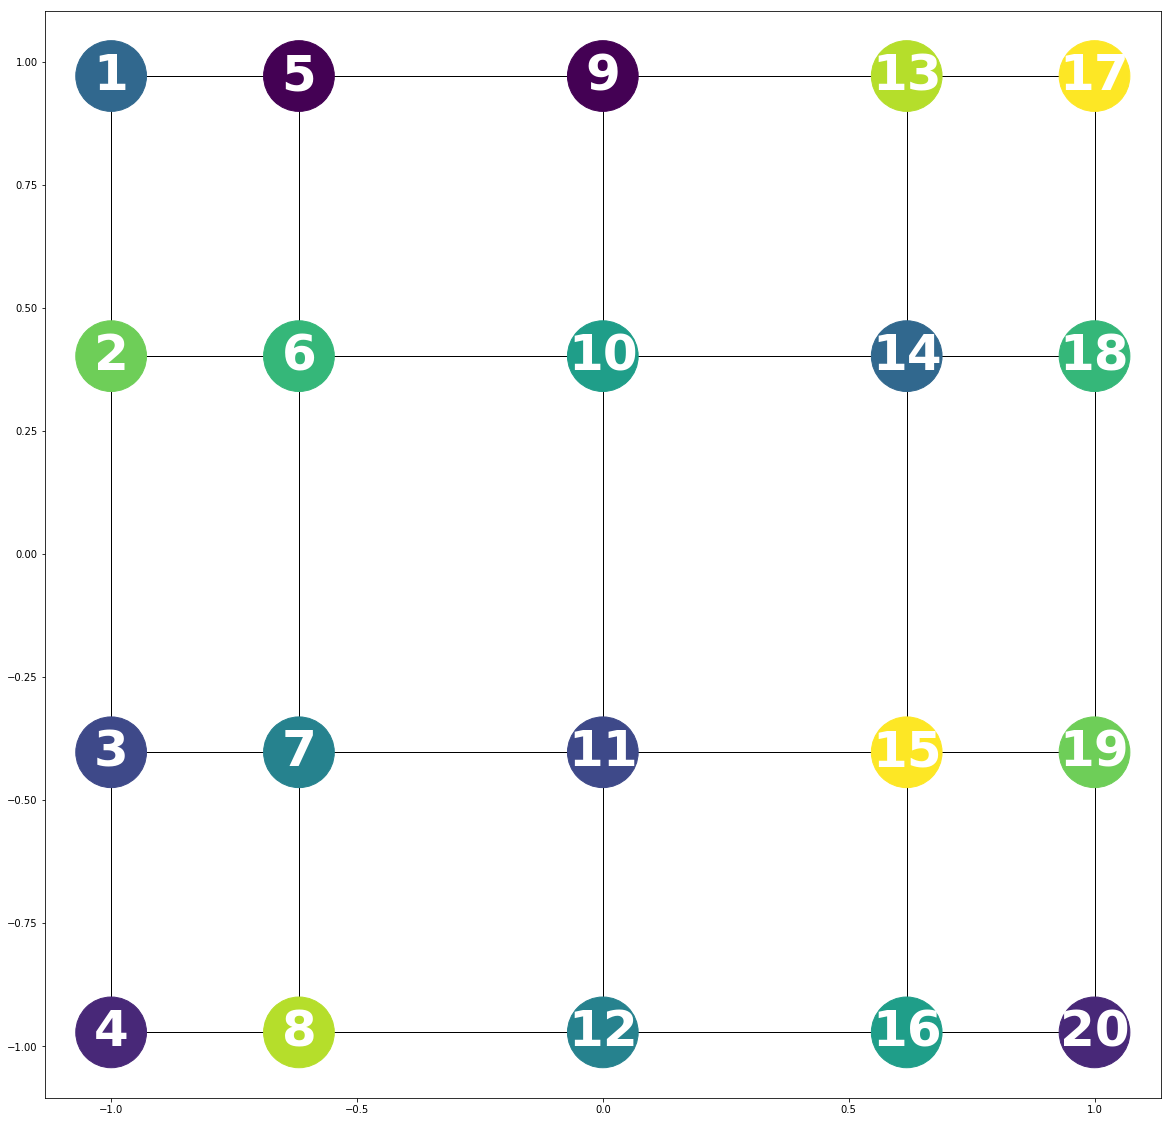

In [8]:
if args.graph == 'Simplest':
    
    G, colour_collection = CreatingSimplestGraph()
            
elif args.graph == 'Colour':
    
    G, colour_collection = CreatColourGraph()
    

In [9]:
if args.path == 'Predicting':
    
    paths = GeneratingAllSimplePath()

    with open("AllSimplePath.txt", "wb") as fp:   #Pickling
         pickle.dump(paths, fp) 
    
elif args.path == 'Cycle':    
    
    G = G.to_directed()
    all_cycle = list(nx.simple_cycles(G))
    all_colour_cycle = IdxToColour_ForCycle(all_cycle)
    Pleft, Pright, Nright = CreateData_NoColourConstrain(all_colour_cycle)
    df = TransferToDf(Pleft, Pright, Nright)
    
    with open("CycleWith"+ str(args.num_colour)+"Colours.txt", "wb") as fp:   #Pickling
        pickle.dump(df, fp)
        
elif args.path == 'Simple':

    data, idx_data = SimplePathCreateData(args.num_pairs, args.root, args.prob, args.random_seed)
#     checking(pd.DataFrame(idx_data))
    df = pd.DataFrame(data)
    display(df)

    with open("SimplestGraphWith"+str(args.num_nodes)+"Nodes_"+str(args.num_pairs)+"Pairs.txt", "wb") as fp:   #Pickling
         pickle.dump(df, fp)

,left,right,target
0,"[4, 1, 7, 5, 3, 2, 9, 5, 6, 2, 8, 10, 4, 9, 1,...","[4, 8, 3, 2, 9, 5, 6, 10, 8, 7, 4, 9, 1, 1, 7,...",1
1,"[4, 1, 7, 5, 3, 2, 9, 5, 6, 2, 8, 10, 4, 9, 1,...","[4, 8, 7, 6, 4, 9, 10, 7, 8, 10, 6, 5, 9, 2, 3]",0
2,"[4, 1, 7, 8, 3, 5, 9, 5, 3, 10, 6, 2, 8, 7, 4, 6]","[4, 8, 7, 5, 9, 5, 3, 10, 4, 6]",1
3,"[4, 1, 7, 8, 3, 5, 9, 5, 3, 10, 6, 2, 8, 7, 4, 6]","[4, 1, 7, 5, 3, 5, 6, 2, 8, 10, 4, 7]",0
4,"[4, 1, 1, 9, 4, 10, 6, 5, 9, 2, 3, 8, 7, 6]","[4, 8, 3, 2, 9, 5, 6, 2, 8, 7, 4, 9, 1, 1, 7, ...",1
5,"[4, 1, 1, 9, 4, 10, 6, 5, 9, 2, 3, 8, 7, 6]","[4, 8, 7, 5, 3, 6, 4, 10, 8, 7, 10, 9, 1, 1]",0
6,"[4, 8, 7, 5, 3, 5, 9, 2]","[4, 1, 1, 9, 10, 7, 8, 10, 4, 6, 7, 8, 3, 2]",1
7,"[4, 8, 7, 5, 3, 5, 9, 2]","[4, 8, 3, 2, 9, 5, 3, 6, 7, 1, 1, 9, 10, 7, 4,...",0
8,"[4, 8, 3, 2, 9, 5, 7, 1, 1, 6, 3, 10, 8, 2, 6, 5]","[4, 1, 1, 9, 10, 7, 4, 10, 6, 5]",1
9,"[4, 8, 3, 2, 9, 5, 7, 1, 1, 6, 3, 10, 8, 2, 6, 5]","[4, 8, 7, 6, 4, 9, 10, 7, 8, 10]",0
